In [146]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt

# Suppress specific sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


In [147]:
# Load the dataset
data = pd.read_csv('C:\\Users\\Bill\\Desktop\\ΑΙ-project\\iphi2802.csv', delimiter='\t', engine='python')

# Display the first few rows to check the data
data.head()

,id,text,metadata,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
0,315181,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,Boiotia — Thespiai — mid-3rd c. BC — BCH 26 (1...,1698,Central Greece (IG VII-IX),1691,"Megaris, Oropia, and Boiotia (IG VII)",mid-3rd c. BC,-275.0,-226.0,0.0
1,201686,μαλκοιδων ηρωνος.,"Crete, W. — Tarrha — 1st-3rd c. AD — IC II xxi...",1699,"Aegean Islands, incl. Crete (IG XI-[XIII])",474,Crete,1st-3rd c. AD,1.0,300.0,0.0
2,153178,βασιλικος.,Makedonia (Bottiaia) — Pella — 3rd/2nd c. BC —...,1692,Northern Greece (IG X),1485,Macedonia,3rd/2nd c. BC,-300.0,-101.0,0.0
3,28582,αισκλαπιει μ [ανεθεκε --].,Epidauria — Epidauros — sinistr. — 6th/5th c. BC,1690,Peloponnesos (IG IV-[VI]),1643,"Epidauria (IG IV²,1)",6th/5th c. BC,-600.0,-401.0,0.0
4,333620,[---]ος αν[εθηκε δαματρι].,Italia — Herakleia (Policoro) — late 4th/early...,1696,"Sicily, Italy, and the West (IG XIV)",1689,"Italy, incl. Magna Graecia",late 4th/early 3rd c. BC,-350.0,-251.0,0.0


In [148]:
# Extract Text and Date Columns
texts = data['text'].values
date_min = data['date_min'].values
date_max = data['date_max'].values

# Compute the midpoint of the date range for regression
date_mid = (date_min + date_max) / 2

# Split the dataset into training and validation sets
x_train_texts, x_val_texts, y_train, y_val, date_min_train, date_min_val, date_max_train, date_max_val = train_test_split(
    texts, date_mid, date_min, date_max, test_size=0.2, random_state=42
)


In [149]:
# Vectorization parameters
NGRAM_RANGE = (1,2)
TOP_K = 1000
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 2

#Training Parameters
LEARNING_RATE = 0.001
MOMENTUM = 0.6
EPOCHS = 60
N_HIDDEN_NODES1 = 128
N_HIDDEN_NODES2 = 8
N_HIDDEN_NODES3 = 4
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)
dropout_rate_input = 0.2
dropout_rate_hidden = 0.8

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors with TF-IDF and normalizes the features."""
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'dtype': 'float64',
        'decode_error': 'strict',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_regression, k=min(TOP_K, x_train.shape[1]))
    x_train = selector.fit_transform(x_train, train_labels).astype('float64')
    x_val = selector.transform(x_val).astype('float64')
    
    return x_train, x_val

# Apply the vectorization 
x_train_vectorized, x_val_vectorized = ngram_vectorize(x_train_texts, y_train, x_val_texts)

In [150]:
# Convert sparse matrices to dense format
x_train_vectorized_dense = x_train_vectorized.toarray()
x_val_vectorized_dense = x_val_vectorized.toarray()

In [151]:
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [152]:
def create_model(input_dim, learning_rate=LEARNING_RATE, n_hidden_nodes=N_HIDDEN_NODES1, n_hidden_nodes2 = N_HIDDEN_NODES2, n_hidden_nodes3 = N_HIDDEN_NODES3):
    """Creates a neural network model."""
    model = Sequential()
    model.add(Dense(n_hidden_nodes, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate_input))
    model.add(Dense(n_hidden_nodes2, activation='relu'))
    model.add(Dropout(dropout_rate_hidden))
    model.add(Dense(n_hidden_nodes3, activation='relu'))
    model.add(Dropout(dropout_rate_hidden))
    model.add(Dense(1))  # Output layer (regression)
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=MOMENTUM, beta_2=0.999) 
    model.compile(optimizer=optimizer, loss= rmse_loss)
    
    return model

# Get the input dimension
input_dim = x_train_vectorized_dense.shape[1]

In [153]:
# Define the custom RMSE function
def custom_rmse(predictions, date_min, date_max):
    """Calculate custom RMSE based on the prediction error relative to the date range."""
    errors = []
    for pred, min_date, max_date in zip(predictions, date_min, date_max):
        if min_date <= pred <= max_date:
            errors.append(0)
        else:
            error = min(abs(pred - min_date), abs(pred - max_date))
            errors.append(error)
    return np.sqrt(np.mean(np.square(errors)))

In [154]:
# Function to plot training and validation losses across folds
def plot_training_history(training_losses, validation_losses):
    plt.figure(figsize=(14, 7))
    
    # Plot training losses for all folds
    for i, losses in enumerate(training_losses):
        plt.plot(losses, label=f'Fold {i+1} Training Loss', linestyle='-', alpha=0.7)
    
    # Plot validation losses for all folds
    for i, losses in enumerate(validation_losses):
        if losses:  # Only plot if there are validation losses
            plt.plot(losses, label=f'Fold {i+1} Validation Loss', linestyle='--', alpha=0.7)
        
    
    plt.title('Training and Validation Losses Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [155]:
# Function to fit and plot the final model
def fit_and_plot_final_model(x_train, y_train, x_val, y_val, date_min_val, date_max_val):
    # Create and compile the model
    model = create_model(input_dim, learning_rate=LEARNING_RATE, n_hidden_nodes=N_HIDDEN_NODES1, n_hidden_nodes2 = N_HIDDEN_NODES2, n_hidden_nodes3 = N_HIDDEN_NODES3)
    
    # Fit the model
    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        callbacks=[early_stopping],
                        validation_data=(x_val, y_val), 
                        verbose=1)  # Set verbose=1 to see training progress
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss', linestyle='--')
    plt.title('Final Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    # Predict on validation data
    predictions = model.predict(x_val).flatten()
    
    # Calculate custom RMSE
    rmse = custom_rmse(predictions, date_min_val, date_max_val)
    print(f'Custom RMSE on Validation Set: {rmse}')

    return model, history

In [156]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(x_data, y_data, date_min, date_max):
    """Evaluates the model using K-Fold cross-validation and custom RMSE."""
    custom_rmse_scores = []
    training_losses = []
    validation_losses = []
    
    for train_index, test_index in kf.split(x_data):
        x_train_cv, x_test_cv = x_data[train_index], x_data[test_index]
        y_train_cv, y_test_cv = y_data[train_index], y_data[test_index]
        date_min_cv, date_max_cv = date_min[train_index], date_max[train_index]

        model = create_model(input_dim, learning_rate=LEARNING_RATE, n_hidden_nodes=N_HIDDEN_NODES1, n_hidden_nodes2 = N_HIDDEN_NODES2, n_hidden_nodes3 = N_HIDDEN_NODES3)
        history = model.fit(x_train_cv, 
                            y_train_cv, 
                            epochs=EPOCHS,
                            callbacks=[early_stopping], 
                            validation_data=(x_test_cv, y_test_cv), 
                            verbose=0 )  # Adjust epochs as needed
        
        # Store training and validation losses
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history.get('val_loss', []))

        predictions = model.predict(x_test_cv).flatten()
        rmse = custom_rmse(predictions, date_min_cv, date_max_cv)
        custom_rmse_scores.append(rmse)
    
    return custom_rmse_scores, training_losses, validation_losses

# Evaluate the model
custom_rmse_scores, training_losses, validation_losses= evaluate_model(x_train_vectorized_dense, y_train, date_min_train, date_max_train)
print("Cross-Validated Custom RMSE Scores:", custom_rmse_scores)
print("Mean Custom RMSE:", np.mean(custom_rmse_scores))
print("Standard Deviation of Custom RMSE:", np.std(custom_rmse_scores))

14/14 [==============================] - 0s 1ms/step
Cross-Validated Custom RMSE Scores: [234.8502746961119, 225.85728802236855, 236.39717845140825, 241.34013042683821, 225.6542158659191]
Mean Custom RMSE: 232.81981749252918
Standard Deviation of Custom RMSE: 6.153676359354289


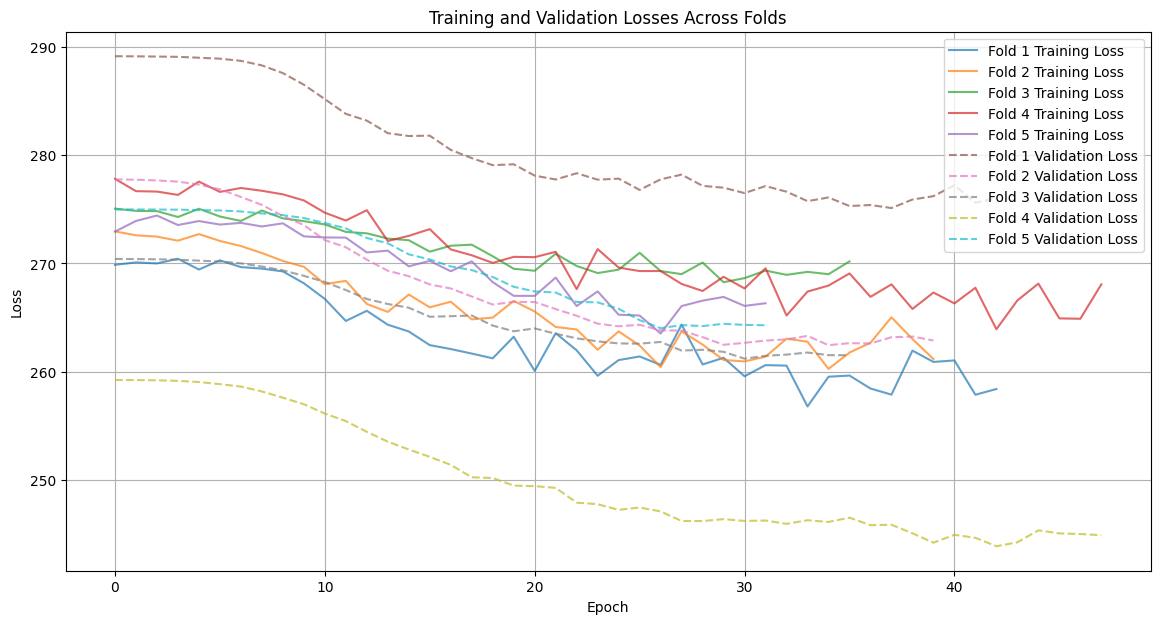

Epoch 1/60
71/71 [==============================] - 1s 3ms/step - loss: 273.6949 - val_loss: 284.4775
Epoch 2/60
71/71 [==============================] - 0s 2ms/step - loss: 273.8841 - val_loss: 284.4711
Epoch 3/60
71/71 [==============================] - 0s 2ms/step - loss: 273.0008 - val_loss: 284.4548
Epoch 4/60
71/71 [==============================] - 0s 2ms/step - loss: 273.7203 - val_loss: 284.4198
Epoch 5/60
71/71 [==============================] - 0s 2ms/step - loss: 273.8072 - val_loss: 284.2286
Epoch 6/60
71/71 [==============================] - 0s 2ms/step - loss: 273.0476 - val_loss: 283.9104
Epoch 7/60
71/71 [==============================] - 0s 2ms/step - loss: 273.0931 - val_loss: 283.1348
Epoch 8/60
71/71 [==============================] - 0s 2ms/step - loss: 272.2363 - val_loss: 282.1320
Epoch 9/60
71/71 [==============================] - 0s 2ms/step - loss: 270.3619 - val_loss: 280.2894
Epoch 10/60
71/71 [==============================] - 0s 2ms/step - loss: 269.4847 

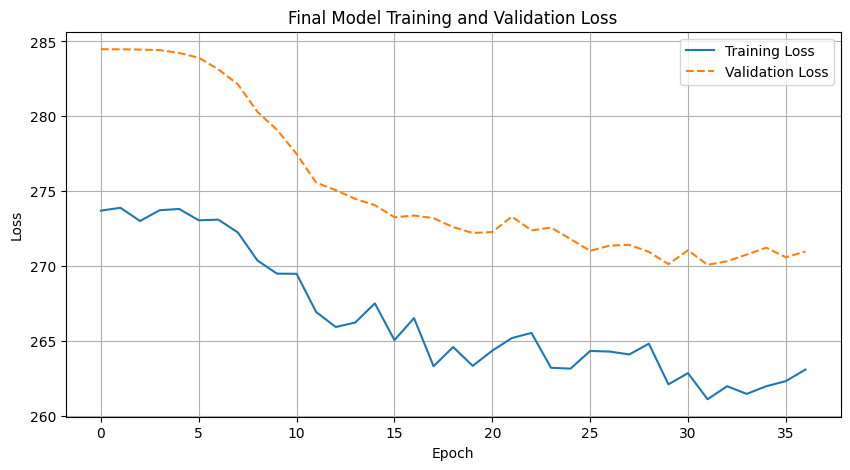

18/18 [==============================] - 0s 882us/step
Custom RMSE on Validation Set: 229.04628769908228


(<keras.engine.sequential.Sequential at 0x2438a8cfc50>,
 <keras.callbacks.History at 0x2438994ed90>)

In [157]:
# Plot the training and validation losses
plot_training_history(training_losses, validation_losses)

# Fit and plot the final model
fit_and_plot_final_model(x_train_vectorized_dense, y_train, x_val_vectorized_dense, y_val, date_min_val, date_max_val)